In [1]:
# Group members: Abdennour Aissaoui , Obaid Muhammad, Ling Feng Zhou, Shiyuan Lin
# Header: 
# Given a list of 1600 ETFs from Wharton Research Data Services, the file selects "Technology" and "Small Cap" ETFs from the list of 1600. 
# Then, it runs clustering algorith (DBSCAN and K-Means) to cluster the selected Technology and Small Cap ETFs.
# Then, it within each cluster (for each clustering algorithm), it finds a list of co-integrated pairs that pass the ADF and Johansen Test.
# Output: Co-integration Pairs using DBSCAN Clustering & Co-integration Pairs using K-Means Clustering

import pandas as pd
import numpy as np

from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# !pip install yfinance
import yfinance as yf

rseed = 99

In [2]:
## Retrieve data functions
def filter_data(etf_data: pd.DataFrame, query: str = None):
    if query: return etf_data.query(query)
    else: return etf_data
    
def load_data(tickers: list, interval: str, start: str, end: str = None) -> pd.DataFrame:
    """
    Downloads data from Yahoo Finance.
    Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    Returns a dataframe with where each column is a ticker
    """
    data = yf.download(tickers,
                       start=start,
                       end=end,
                       interval=interval,
                       progress=False).dropna()

    return data[["Close"]]


def run_with_query(etf_data: pd.DataFrame, interval: str, query: str = None,
                   start: str = None, end: str = None) -> pd.DataFrame:
    '''
    Retrives the data from Yahoo Finance. It gets the tickers by applying a pandas dataframe query to etf_data.
    :param etf_data:
    :param interval: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    :param query: query that filters the tickers
    :param start:
    :param end:
    :return: a dataframe with where each column is a ticker
    '''
    remove_tickers = ['ARKQ', 'OGIG']
    
    filtered_data = filter_data(etf_data, query)
    tickers = filtered_data['Ticker'].unique().tolist()
    for tic in remove_tickers:
        if tic in tickers:
            tickers.remove(tic)
    return load_data(tickers, interval, start, end)

In [3]:
# Co-integration functions
def _transform_prices(prices, transformation):
    """
    Transformation: None for testing co-integration on prices, log for for log prices, logret for log return
    """
    if transformation == "log":
        return np.log(prices)
    elif transformation == "logret":
        return np.log(prices/prices.shift())
    else:
        return prices
    

def _check_johansen(ts, confidence_level):
    """
    returns a tuple of True or False for passing or failling the test at @confidence_level + hedge ratio if passed test
    """
    # the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
    # eigenvalue statistic are stored in the first, second, and third column of 
    # cvt and cvm, respectively
    result = coint_johansen(ts, 0, 1)
    confidence_level_cols = {
        90: 0,
        95: 1,
        99: 2
    }
    confidence_level_col = confidence_level_cols[confidence_level]
    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    
    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        return True, v1.flatten()
    return False, 0
    
def _check_adf(ts, confidence_level):
    alpha =(100- confidence_level) / 100
    p_val = adfuller(ts)[1]
    passed_adf = alpha > p_val
    return passed_adf

def _cointegrated(ts, confidence_level):
    """
    Performs Johansen  + ADF tests. Returns True iff the Series passes both tests 
    """
    passed_adf = False
    passed_johansen, eivec = _check_johansen(ts, confidence_level)
    if passed_johansen:
        spread = (eivec * ts).sum(axis=1)
        passed_adf =  _check_adf(spread, confidence_level)
    return passed_adf

def get_cointegrating_pairs(prices, transformation=None, confidence_level=90, verbose=False) -> list:
    """
    Given a dataframe of assets prices, this function tests for co-integration for each possible
    pair of assets 

    Transformation: None for testing co-integration on prices, log for for log prices, logret for log return
    # confidence_level: cointegration at 90%, 95%, or 99% confidence 
    """
    # transform (or not) the prices to the desired variable (ex: log (price))
    ts = _transform_prices(prices, transformation)
    possible_pairs = itertools.combinations(list(prices.columns), 2)
    cointegrating_pairs = []
    for pair in possible_pairs:
        if _cointegrated(ts[list(pair)], confidence_level):
            list_pair = list(pair)
            cointegrating_pairs.append(list_pair)
    return cointegrating_pairs

In [4]:
ALLETFS = pd.read_csv("us_etf_db_recent.csv")

# Possible_Fields = ['Focus']
# Possible_Values = ['Technology', 'Small Cap]

FIELD = 'Focus'
VALUE = 'Small Cap'
# VALUE = 'Technology'

QUERY =  FIELD + " == " + '"' + VALUE + '"' 

FIELD_SERIES = ALLETFS[FIELD]
FIELD_SERIES.value_counts()

Total Market              403
Large Cap                 204
Investment Grade          104
Small Cap                  88
Broad Market               78
Technology                 53
High Yield                 48
Energy                     46
Theme                      41
Financials                 39
Mid Cap                    38
Health Care                37
Target Outcome             35
Basic Materials            35
Treasury                   34
High Dividend Yield        33
Real Estate                30
Industrials                27
Consumer Cyclicals         24
Long/Short                 17
Consumer Non-cyclicals     15
Gold                       14
Preferred Stock            14
Utilities                  14
Global Macro               12
TIPS                       11
Extended Market             9
Target Risk                 8
Silver                      7
Volatility                  7
Telecommunications          7
Crude Oil                   7
Euro                        6
Japanese Y

In [5]:
# INTERVAL = '5m'
# START = "2020-12-15"
# END = None

INTERVAL = '1d'
START = "2017-11-10"
END = "2019-11-29"

ETFdata = run_with_query(ALLETFS, INTERVAL, QUERY, START, END) 
ETFdata = ETFdata['Close']

In [6]:
ETFdata

,ASHS,BRF,CALF,CSA,CSB,CSF,CSML,DDLS,DES,DFE,...,VB,VBK,VBR,VSS,VTWG,VTWO,VTWV,XSHD,XSHQ,XSLV
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-10,36.419998,22.860001,24.427999,44.020000,42.058998,43.040001,27.020000,32.500000,27.690001,67.790001,...,142.360001,155.539993,127.449997,116.099998,129.699997,117.669998,105.900002,24.920000,25.917999,45.950001
2017-11-13,36.480000,22.879999,24.427999,44.020000,41.880001,43.080002,26.990000,32.320000,27.670000,67.160004,...,142.380005,155.559998,127.540001,115.239998,129.619995,117.730003,105.669998,24.730000,25.917999,46.060001
2017-11-14,36.189999,22.260000,24.232000,44.119999,41.919998,43.180000,26.930000,32.180000,27.709999,67.400002,...,142.020004,155.000000,127.250000,115.309998,128.880005,117.440002,105.320000,24.719999,25.740000,46.139999
2017-11-15,35.740002,22.400000,24.250000,44.050999,41.814999,42.910000,26.790001,31.889999,27.590000,66.750000,...,141.350006,154.130005,126.629997,114.650002,128.520004,116.940002,104.910004,24.860001,25.740000,45.910000
2017-11-16,36.070000,23.260000,24.250000,44.050999,42.619999,43.540001,27.260000,32.230000,28.120001,67.349998,...,143.100006,156.289993,128.100006,115.910004,130.899994,118.599998,106.169998,25.020000,25.740000,46.419998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-21,25.709999,23.889999,25.334999,47.703999,45.740002,38.025002,26.306999,31.549000,27.660000,59.709999,...,159.729996,191.250000,132.279999,106.839996,147.899994,126.769997,107.059998,23.695999,27.872999,49.860001
2019-11-22,25.469999,24.049999,25.514999,47.897999,45.898998,38.185001,26.440001,31.655001,27.690001,59.950001,...,160.110001,191.800003,132.720001,106.940002,148.300003,127.199997,107.419998,23.719999,27.950001,49.860001
2019-11-25,25.580000,24.059999,26.309999,48.805000,46.706001,38.924999,27.023001,31.990000,28.129999,60.230000,...,162.630005,195.039993,134.470001,107.660004,151.940002,129.910004,109.309998,24.132000,28.600000,50.520000


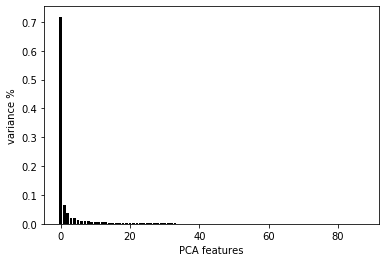

In [7]:
ETFreturn = ETFdata.pct_change().dropna()

pca = PCA(random_state=rseed)
pca.fit(ETFreturn)

# calculate the number of components needed to explain the var_threshold and assign it to pca_components
var_threshold = 0.9

explained_variance = pca.explained_variance_
num_pca_components = np.min(np.argwhere(np.cumsum(pca.explained_variance_ratio_)>var_threshold))+1

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.show()

In [8]:
pca = PCA(n_components = num_pca_components, random_state=rseed)

#Get the weights of each return column for each PCA
pca.fit(ETFreturn)
X = pca.components_.T

X = preprocessing.StandardScaler().fit_transform(X)

## DB Scan

In [9]:
cluster = DBSCAN(min_samples=3)

cluster.fit(X)

clustered = cluster.labels_
n0_clusters = len(set(clustered)) - (1 if -1 in clustered else 0)
print("\nClusters discovered: %d" % n0_clusters)

clustered = cluster.labels_

clustered_series_all = pd.Series(index=ETFreturn.columns, data=clustered.flatten())
clustered_series = pd.Series(index=ETFreturn.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]


Clusters discovered: 5


Text(0.5, 1.0, 'T-SNE of all ETFs with DBSCAN Clusters')

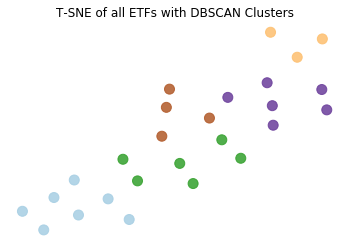

In [10]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=rseed).fit_transform(X)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(clustered!=-1), 0],
    X_tsne[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.title('T-SNE of all ETFs with DBSCAN Clusters')

In [11]:
# plt.barh(
#     range(len(clustered_series.value_counts())),
#     clustered_series.value_counts()
# )
# plt.title('Cluster Member Counts')
# plt.xlabel('Stocks in Cluster')
# plt.ylabel('Cluster Number');

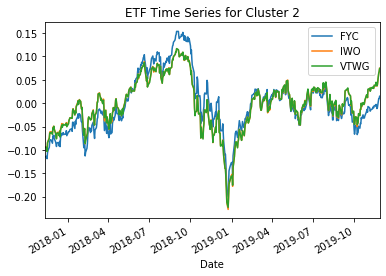

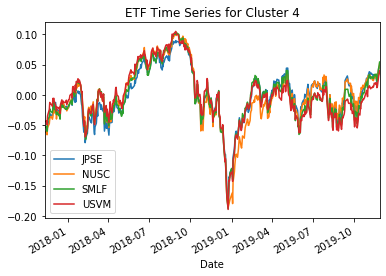

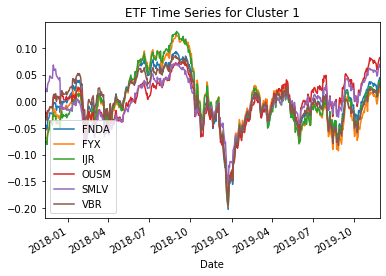

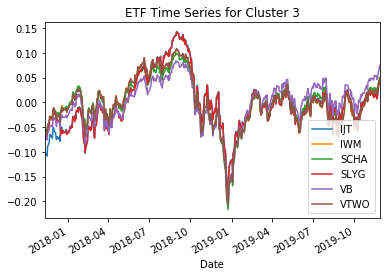

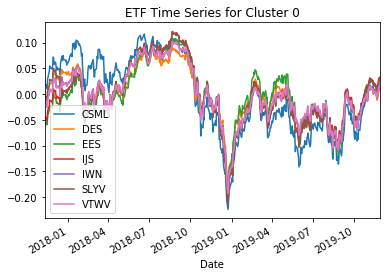

In [12]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters that don't have too many stocks 
selected_clusters = list(counts[(counts<10) & (counts>2)].index)[::-1]

for clust in selected_clusters:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(ETFdata[tickers].mean())
    data = np.log(ETFdata[tickers]).sub(means)
    data.plot(title='ETF Time Series for Cluster %d' % clust)

In [13]:
selected_clusters = list(counts[(counts>2)].index)[::-1]
DBSCAN_cluster_tick_list = []

for clust in selected_clusters:
    cluster_ = list(clustered_series[clustered_series==clust].index)
    print(cluster_)
    DBSCAN_cluster_tick_list.append(cluster_)

['FYC', 'IWO', 'VTWG']
['JPSE', 'NUSC', 'SMLF', 'USVM']
['FNDA', 'FYX', 'IJR', 'OUSM', 'SMLV', 'VBR']
['IJT', 'IWM', 'SCHA', 'SLYG', 'VB', 'VTWO']
['CSML', 'DES', 'EES', 'IJS', 'IWN', 'SLYV', 'VTWV']


In [14]:
cluster_no_list = []
pair_1_list = []
pair_2_list = []

for clust in selected_clusters:
    cluster_ = list(clustered_series[clustered_series==clust].index)
    pairs = get_cointegrating_pairs(ETFdata[cluster_], transformation=None, confidence_level=90, verbose=False)
#     print(pairs)
    if len(pairs) == 0:
        pass
    else:
        for pair in pairs:
            pair_1 = pair[0]
            pair_2 = pair[1]
            cluster_no_list.append(clust)
            pair_1_list.append(pair_1)
            pair_2_list.append(pair_2)
            
data = {'cluster_no':cluster_no_list,
        'pair_1':pair_1_list, 
        'pair_2':pair_2_list}

df_DBSCAN = pd.DataFrame(data) 
csv_name = VALUE + '_DBSCAN.csv'
df_DBSCAN.to_csv(csv_name) 

## K-Means

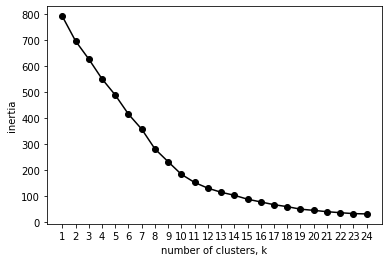

In [15]:
ks = range(1, 25)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=rseed)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [16]:
clf =  KMeans(n_clusters=10, random_state=rseed)

clf.fit(X)

labels = clf.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_
clustered_series = pd.Series(index=ETFreturn.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=ETFreturn.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

Text(0.5, 1.0, 'T-SNE of all ETFs with K-means Clusters')

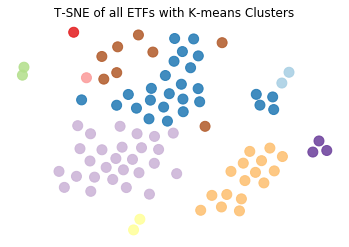

In [17]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=rseed).fit_transform(X)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    s=100,
    alpha=0.85,
    c=labels,
    cmap=cm.Paired
)
plt.title('T-SNE of all ETFs with K-means Clusters')

In [18]:
# plt.barh(
#     range(len(clustered_series.value_counts())),
#     clustered_series.value_counts()
# )
# plt.title('Cluster Member Counts')
# plt.xlabel('Stocks in Cluster')
# plt.ylabel('Cluster Number');

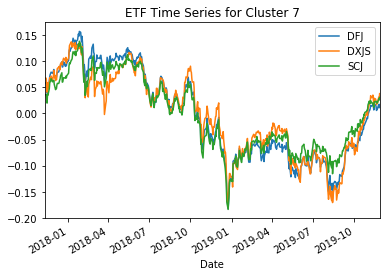

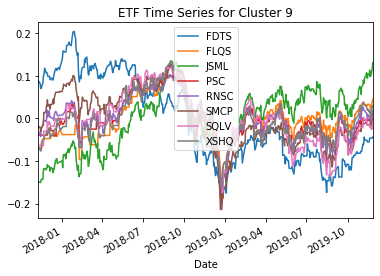

In [19]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters that don't have too many stocks 
selected_clusters = list(counts[(counts<10) & (counts>2)].index)[::-1]

for clust in selected_clusters:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(ETFdata[tickers].mean())
    data = np.log(ETFdata[tickers]).sub(means)
    data.plot(title='ETF Time Series for Cluster %d' % clust)

In [20]:
selected_clusters = list(counts[(counts>2)].index)[::-1]
cluster_tick_list = []

for clust in selected_clusters:
    cluster_ = list(clustered_series[clustered_series==clust].index)
    print(cluster_)
    cluster_tick_list.append(cluster_)

['DFJ', 'DXJS', 'SCJ']
['FDTS', 'FLQS', 'JSML', 'PSC', 'RNSC', 'SMCP', 'SQLV', 'XSHQ']
['DDLS', 'DFE', 'DLS', 'EUSC', 'EWGS', 'EWUS', 'FNDC', 'GWX', 'HSCZ', 'IEUS', 'ISCF', 'RSXJ', 'SCHC', 'SCZ', 'SMEZ', 'VSS']
['DGS', 'DWAS', 'EEMS', 'EWX', 'FEMS', 'FYC', 'FYX', 'GSSC', 'IJT', 'IWM', 'IWO', 'JHSC', 'JKK', 'JPSE', 'NUSC', 'RZG', 'SCHA', 'SLYG', 'SMLF', 'SMMV', 'TNA', 'USVM', 'VB', 'VBK', 'VTWG', 'VTWO']
['CALF', 'CSA', 'CSB', 'CSF', 'CSML', 'DES', 'DGRS', 'EES', 'EWSC', 'FNDA', 'FYT', 'IJR', 'IJS', 'IWN', 'JKJ', 'JKL', 'OMFS', 'OUSM', 'RWJ', 'RZV', 'SLYV', 'SMDV', 'SMLV', 'VBR', 'VTWV', 'XSHD', 'XSLV']


In [21]:
cluster_no_list = []
pair_1_list = []
pair_2_list = []

for clust in selected_clusters:
    cluster_ = list(clustered_series[clustered_series==clust].index)
    pairs = get_cointegrating_pairs(ETFdata[cluster_], transformation=None, confidence_level=90, verbose=False)
#     print(pairs)
    if len(pairs) == 0:
        pass
    else:
        for pair in pairs:
            pair_1 = pair[0]
            pair_2 = pair[1]
            cluster_no_list.append(clust)
            pair_1_list.append(pair_1)
            pair_2_list.append(pair_2)
            
data = {'cluster_no':cluster_no_list,
        'pair_1':pair_1_list, 
        'pair_2':pair_2_list}

df_kmeans = pd.DataFrame(data) 
csv_name = VALUE + '_kmeans.csv'
df_kmeans.to_csv(csv_name) 

In [22]:
df_DBSCAN

,cluster_no,pair_1,pair_2
0,2,IWO,VTWG
1,4,NUSC,SMLF
2,1,OUSM,SMLV
3,3,IJT,SLYG
4,3,IWM,VTWO
5,0,IJS,SLYV
6,0,IWN,SLYV
7,0,IWN,VTWV
8,0,SLYV,VTWV


In [23]:
df_kmeans

,cluster_no,pair_1,pair_2
0,9,PSC,RNSC
1,9,PSC,XSHQ
2,9,RNSC,SMCP
3,9,RNSC,XSHQ
4,1,DGS,FYC
5,1,DGS,IJT
6,1,DGS,IWO
7,1,DGS,SLYG
8,1,GSSC,SMLF
9,1,GSSC,USVM
